<a href="https://colab.research.google.com/github/gigug/PML/blob/main/PML_project_TicTacToe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tic Tac Toe with MDP

Libraries

In [ ]:
import math
import numpy as np
import pprint
import pickle
import matplotlib.pyplot as plt
from google.colab import files

Defining board size

In [ ]:
rows = 3
cols = 3

Useful functions

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def separator(a, n = 100):
    wins = np.zeros((len(a)))
    losses = np.zeros((len(a)))
    ties = np.zeros((len(a)))
    index = 0
    for i in a:
        if i == 1:
            wins[index] = 1
        if i == -1:
            losses[index] = 1
        if i == 0:
            ties[index] = 1
        index += 1

    cu_wins = moving_average(wins, n)[::n]
    cu_losses = moving_average(losses, n)[::n]
    cu_ties = moving_average(ties, n)[::n]

    x_axis = range(len(cu_wins))

    return x_axis, cu_wins, cu_losses, cu_ties

Defining AI player's class

In [ ]:
class AI_player:
  def __init__(self, name, exp_rate = 0.3, sarsa = True):
    self.name = name
    self.states = [] # record all positions taken, necessary for reward
    self.lr = 0.2
    self.exp_rate = exp_rate 
    self.decay_gamma = 0.9
    self.states_value = {} # value of state
    self.inde = 0
    self.symbol = None
    self.sarsa = sarsa
  
  # Return hashed board
  # Needed to save and check policies
  def get_hash(self, board):
    board_hash = str(board.reshape(cols * rows))
    return board_hash

  # Choose and return action
  def choose_action(self, positions, current_board, symbol, on = False):
    self.symbol = symbol
    # Take random action
    if np.random.uniform(0, 1) <= self.exp_rate:
      idx = np.random.choice(len(positions))
      action = positions[idx]
    
    # Take action that maximizes value in the next step
    else:
      value_max = -math.inf
      for p in positions:
        next_board = current_board.copy()
        next_board[p] = symbol
        next_board_hash = self.get_hash(next_board)
        value = 0 if self.states_value.get(next_board_hash) is None else self.states_value.get(next_board_hash)
        
        # Get best choice
        if value >= value_max:
          value_max = value
          action = p
    if on:
      return value_max
    return action

  # Add state to history
  def add_state(self, state):
    self.states.append(state)

  # Backpropagate and update states value
  def feed_reward(self, reward):
    self.inde += 1
    for state in reversed(self.states):
      # Initialize new state's value
      if self.states_value.get(state) is None:
        self.states_value[state] = 0

      # Last reward state becomes reward
      self.states_value[state] += self.lr * (self.decay_gamma * reward - self.states_value[state])
      av = self.available_positions(self.states_value)
      if self.sarsa:
        reward = self.states_value[state]
      else:
        if len(av) > 0:
          reward = self.choose_action(av, state, self.symbol, on = True)
        else:
          reward = self.states_value[state]
    
  def available_positions(self, board):
    positions = []
    for key, value in board.items():
      board = key
    for i in range(rows):
      for j in range(cols):
        if board[i * cols + j] == 0:
          positions.append((i, j))
    return positions

  # Reset states
  def reset(self):
    self.states = []

  # Save policy on file
  def save_policy(self):
    fi = open('policy_' + str(self.name), 'wb')
    pickle.dump(self.states_value, fi)
    fi.close()

  # Load policy from file
  def load_policy(self, file):
    fi = open(file, 'rb')
    self.states_value = pickle.load(fi)
    fi.close()

Defining human player's class

In [ ]:
class human_player:
    def __init__(self, name):
        self.name = name

    def choose_action(self, positions):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions:
                return action

Defining State class

In [ ]:
class state:
  def __init__(self, player1, player2, reward_win = 1, reward_loss = 0, reward_tie_x = 0.2, reward_tie_o = 0.2):
    # Defining initial board
    self.board = np.zeros((rows, cols))

    # Defining roles (AI or Human)
    self.p1 = player1
    self.p2 = player2
    self.end = False
    self.board_hash = None

    # First player p1
    self.player_symbol = 1
  
  # AI vs AI
  def play(self, rounds = 1000):
    self.wins = np.zeros(rounds)
    index = 0
    for i in range(rounds):
      # Print round
      if i % 1000 == 0:
        print("Rounds {}".format(i))

      while not self.end:
        # Player 1
        positions = self.available_positions()
        p1_action = self.p1.choose_action(positions, self.board, self.player_symbol)
        # take action and upate board state
        self.update_state(p1_action)
        board_hash = self.get_hash()
        self.p1.add_state(board_hash)
        # check board status if it is end

        win = self.winner()
        if win is not None:
            # ended with p1 either win or draw
            if win == 1:
                self.wins[index] = 1
            else:
                pass
            index += 1
            self.close_reward()
            break

        else:
            # Player 2
            positions = self.available_positions()
            p2_action = self.p2.choose_action(positions, self.board, self.player_symbol)
            self.update_state(p2_action)
            board_hash = self.get_hash()
            self.p2.add_state(board_hash)

            win = self.winner()
            if win is not None:
                if win == -1:
                    self.wins[index] = -1
                else:
                    pass
                index += 1
                # ended with p2 either win or draw
                self.close_reward()
                break
                
  def close_reward(self):
    self.reward()
    self.p1.reset()
    self.p2.reset()
    self.reset()

  # AI vs human
  def play_human(self):
    turn = isinstance(p1, human_player)
    print(turn)
    while not self.end:
        
        # Player 1
        positions = self.available_positions()
        if turn == False:
            p1_action = self.p1.choose_action(positions, self.board, self.player_symbol)
        else:
            p1_action = self.p1.choose_action(positions)
        # take action and upate board state
        self.update_state(p1_action)
        print_board(self)
        # check board status if it is end
        win = self.winner()
        if win is not None:
            if win == 1:
                print(self.p1.name, "wins!")
            else:
                print("tie!")
            self.reset()
            break
        

        else:
            # Player 2
            positions = self.available_positions()
            if turn == False:
                p2_action = self.p2.choose_action(positions)
            else:
                p2_action = self.p2.choose_action(positions, self.board, self.player_symbol)

            self.update_state(p2_action)
            print_board(self)
            win = self.winner()
            if win is not None:
                if win == -1:
                    print(self.p2.name, "wins!")
                else:
                    print("tie!")
                self.reset()
                break


  def get_hash(self):
    self.board_hash = str(self.board.reshape(cols * rows))
    return self.board_hash

  def winner(self):
    # row
    for i in range(rows):
        if sum(self.board[i, :]) == 3:
            self.end = True
            return 1
        if sum(self.board[i, :]) == -3:
            self.end = True
            return -1
    # col
    for i in range(cols):
        if sum(self.board[:, i]) == 3:
            self.end = True
            return 1
        if sum(self.board[:, i]) == -3:
            self.end = True
            return -1
    # diagonal
    diag_sum1 = sum([self.board[i, i] for i in range(3)])
    diag_sum2 = sum([self.board[i, cols - i - 1] for i in range(3)])
    diag_sum = max(abs(diag_sum1), abs(diag_sum2))
    if diag_sum == 3:
        self.end = True
        if diag_sum1 == 3 or diag_sum2 == 3:
            return 1
        else:
            return -1

    # tie
    # no available positions
    if len(self.available_positions()) == 0:
        self.end = True
        return 0
    # not end
    self.end = False
    return None

  def available_positions(self):
    positions = []
    for i in range(rows):
      for j in range(cols):
        if self.board[i, j] == 0:
          positions.append((i, j))
    return positions

  def update_state(self, position):
    # Write action
    self.board[position] = self.player_symbol

    # Switch symbol
    self.player_symbol = -1 if self.player_symbol == 1 else 1

  def reward(self):
    result = self.winner()

    # Backpropagate reward
    if result == 1:
      self.p1.feed_reward(reward_win)
      self.p2.feed_reward(reward_loss)
    elif result == -1:
      self.p1.feed_reward(reward_loss)
      self.p2.feed_reward(reward_win)
    else:
      self.p1.feed_reward(reward_tie_x)
      self.p2.feed_reward(reward_tie_o)

  # Reset board and properties
  def reset(self):
    self.board = np.zeros((rows, cols))
    self.board_hash = None
    self.end = False
    self.player_symbol = 1

# Print board
def print_board(self):
    for i in range(0, rows):
      print ('--------------')
      out = '| '
      for j in range(0, cols):
        if self.board[i, j] == 1:
          token = 'x'
        if self.board[i, j] == -1:
          token = 'o'
        if self.board[i, j] == 0:
          token = ' '
        out += token + ' | '
      print(out)
    print('-------------')



Training *X* VS Random Opponent, SARSA and parameters:


In [ ]:
exp_rate_x = 0.1
reward_win = 1
reward_loss = 0
reward_tie_x = 0.1
reward_tie_o = 0.1

p1_1 = AI_player("p1_1", exp_rate = 0.1)
p2_1 = AI_player("p2_1", exp_rate = 1)

x_learn_1 = state(p1_1, p2_1)
print("Training X")
x_learn_1.play(100000)

p1_1.save_policy()

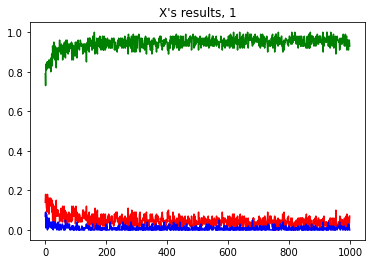

In [ ]:
x_axis, cu_wins_1, cu_losses_1, cu_ties_1 = separator(x_learn_1.wins, n = 100)

plt.plot(x_axis, cu_wins_1, color = 'green')
plt.plot(x_axis, cu_losses_1, color = 'red')
plt.plot(x_axis, cu_ties_1, color = 'blue')
plt.title("X's results, 1")
plt.show()

Training *X* VS Random Opponent, Q-learning and parameters:

In [ ]:
exp_rate_x = 0.1
reward_win = 1
reward_loss = 0
reward_tie_x = 0.1
reward_tie_o = 0.1

p1_2 = AI_player("p1_2", exp_rate = 0.1, sarsa = False)
p2_2 = AI_player("p2_2", exp_rate = 1)

x_learn_2 = state(p1_2, p2_2)
print("Training X")
x_learn_2.play(50000)

p1_2.save_policy()

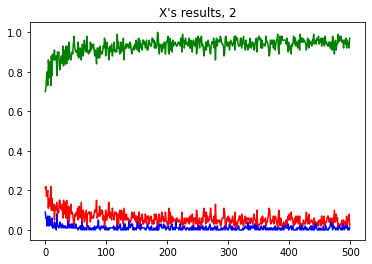

In [ ]:
x_axis, cu_wins, cu_losses, cu_ties = separator(x_learn_2.wins, n = 100)

plt.plot(x_axis, cu_wins, color = 'green')
plt.plot(x_axis, cu_losses, color = 'red')
plt.plot(x_axis, cu_ties, color = 'blue')
plt.title("X's results, 2")
plt.show()

# Can't play with human

Training *X* VS Learning Opponent, SARSA and parameters:

In [ ]:
exp_rate_x = 0.1
exp_rate_o = 0.1
reward_win = 1
reward_loss = 0
reward_tie_x = 0.1
reward_tie_o = 0.1

p1_3 = AI_player("p1_3", exp_rate = exp_rate_x)
p2_3 = AI_player("p2_3", exp_rate = exp_rate_o)

x_learn_3 = state(p1_3, p2_3)
print("Training X")
x_learn_3.play(100000)

p1_3.save_policy()

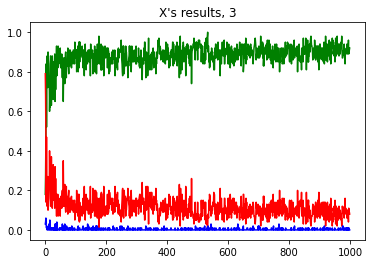

In [ ]:
x_axis, cu_wins, cu_losses, cu_ties = separator(x_learn_3.wins, n = 100)

plt.plot(x_axis, cu_wins, color = 'green')
plt.plot(x_axis, cu_losses, color = 'red')
plt.plot(x_axis, cu_ties, color = 'blue')
plt.title("X's results, 3")
plt.show()


Training *X* VS Learning Opponent, Q-learning and parameters:

In [ ]:
exp_rate_x = 0.1
exp_rate_o = 0.1
reward_win = 1
reward_loss = 0
reward_tie_x = 0.1
reward_tie_o = 0.1

p1_4 = AI_player("p1_4", exp_rate = exp_rate_x, sarsa = False)
p2_4 = AI_player("p2_4", exp_rate = exp_rate_o, sarsa = False)

x_learn_4 = state(p1_4, p2_4)
print("Training X")
x_learn_4.play(100000)

p1_4.save_policy()

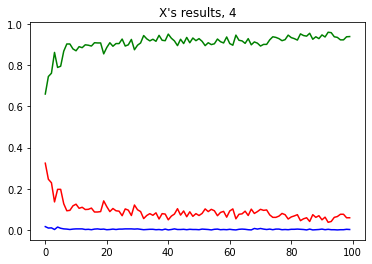

In [ ]:
x_axis, cu_wins, cu_losses, cu_ties = separator(x_learn_5.wins, n = 1000)

plt.plot(x_axis, cu_wins, color = 'green')
plt.plot(x_axis, cu_losses, color = 'red')
plt.plot(x_axis, cu_ties, color = 'blue')
plt.title("X's results, 5")
plt.show()

Training *X* VS Learning Opponent, SARSA and parameters:

In [ ]:
exp_rate_x = 0.1
exp_rate_o = 0.1
reward_win = 1
reward_loss = -1
reward_tie_x = -1
reward_tie_o = 1

p1_5 = AI_player("p1_5", exp_rate = exp_rate_x)
p2_5 = AI_player("p2_5", exp_rate = exp_rate_o)

x_learn_5 = state(p1_5, p2_5, reward_win = reward_win, reward_loss = reward_loss, reward_tie_x = reward_tie_x, reward_tie_o = reward_tie_o)
print("Training X")
x_learn_5.play(100000)

p1_5.save_policy()

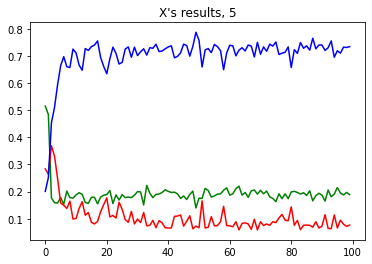

In [ ]:
x_axis, cu_wins, cu_losses, cu_ties = separator(x_learn_5.wins, n = 1000)

plt.plot(x_axis, cu_wins, color = 'green')
plt.plot(x_axis, cu_losses, color = 'red')
plt.plot(x_axis, cu_ties, color = 'blue')
plt.title("X's results, 5")
plt.show()

In [ ]:
p1 = AI_player("computer", exp_rate = 0)
p1.load_policy("policy_p1_5")

p2 = human_player("human")

sta = state(p1, p2)
sta.play_human()


#files.download('policy_p1')
#files.download('policy_p2')

Show Q-table values for initial move

In [ ]:
pp = pprint.PrettyPrinter(indent=4)

p1 = open('policy_p1', 'rb')
policy1 = pickle.load(p1)

q_table_x_1 = np.zeros((rows * cols))
for i in range(9):
    board = np.zeros((rows * cols))
    board[i] = 1
    q_table_x_1[i] = round(policy1.get(str(board)), 3)

pp.pprint(q_table_x_1)

p2 = open('policy_p2', 'rb')
policy2 = pickle.load(p2)

q_table_o_1 = np.zeros((rows * cols))

for i in range(9):
    if i != 4:
        board = np.zeros((rows * cols))
        board[i] = -1
        board[4] = 1
        q_table_o_1[i] = round(policy2.get(str(board)), 3)

pp.pprint(q_table_o_1)